### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 8
### Due: Friday, Apr 11th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

#### Part 1

In [1]:
import numpy as np



data = np.load('../../../homeworks/hw_data/hw8_data_1.npy')


print("There are %.i columns with names: " %len(data.dtype.names), data.dtype.names)

u = data['u']
g = data['g']
r = data['r']
i = data['i']
z = data['z']
specClass = data['specClass']
redshift = data['redshift']
redshift_err = data['redshift_err']

u_m_g = u-g
g_m_r = g-r
r_m_i = r-i
i_m_z = i-z

n_galaxy = [i for i in range(len(specClass)) if specClass[i]=='GALAXY']
n_quasars = [i for i in range(len(specClass)) if specClass[i]=='QSO']

print("There are %i Galaxies" %len(n_galaxy),"and %i Quasars" %len(n_quasars))

There are 8 columns with names:  ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
There are 42808 Galaxies and 7192 Quasars


#### Part 2

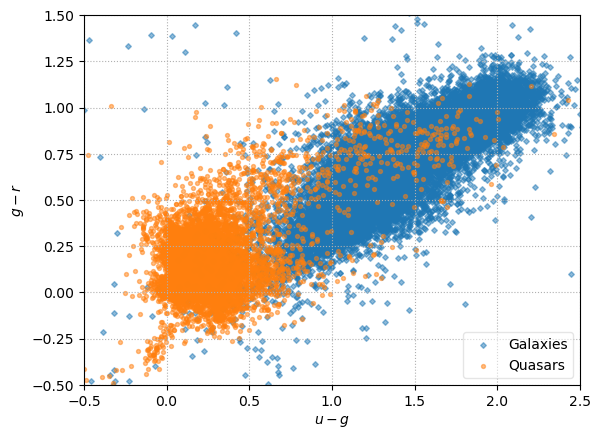

In [2]:
import matplotlib.pyplot as plt


plt.scatter(u_m_g[n_galaxy], g_m_r[n_galaxy], c='tab:blue', marker='D', alpha=0.5, s=8, label='Galaxies')
plt.scatter(u_m_g[n_quasars], g_m_r[n_quasars], c='tab:orange', alpha=0.5, s=8, label='Quasars')

plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)

plt.xlabel(r'$u-g$')
plt.ylabel(r'$g-r$')

plt.legend(framealpha=0.5)
plt.grid(True, ls=':')

plt.show()

#### Part 3

In [3]:
from sklearn.model_selection import train_test_split



X = np.vstack([u_m_g, g_m_r, r_m_i, i_m_z, redshift]).T

target_label = np.array([1 if specClass[i]=='QSO' else 0 for i in range(len(specClass))])

X_train, X_test, y_train, y_test = train_test_split(X, target_label, test_size=0.2, random_state=0)

#### Part 4

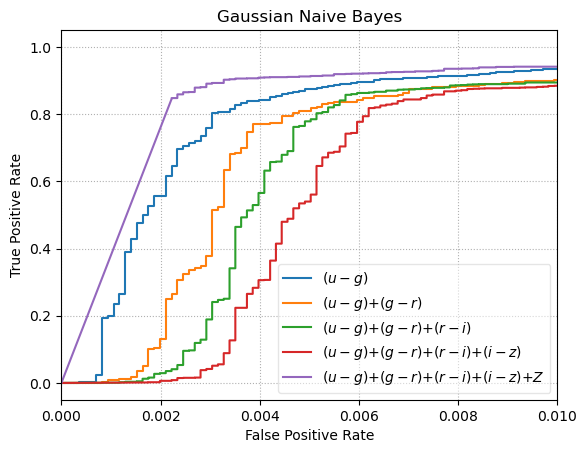

The one with redshift (Z)


In [4]:
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics

features = ['$(u - g)$', '$(g - r)$', '$(r - i)$', '$(i - z)$', '$Z$']

for i in range(1, 6):
    clf = GaussianNB()
    clf.fit(X_train[:, :i], y_train)
    y_prob = clf.predict_proba(X_test[:, :i])[:, clf.classes_ == 1]
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob.flatten())
    plt.plot(fpr, tpr, label=f'{"+".join(features[:i])}')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 0.01)
plt.grid(True, ls=':')
plt.legend(framealpha=0.5)
plt.title("Gaussian Naive Bayes")
plt.show()

print("The one with redshift (Z)")

#### Part 5

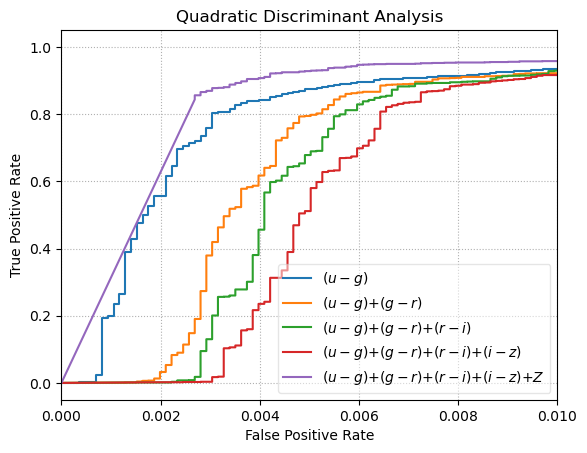

In [5]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA


for i in range(1, 6):
    clf = QDA()
    clf.fit(X_train[:, :i], y_train)
    y_prob = clf.predict_proba(X_test[:, :i])[:, clf.classes_ == 1]
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob.flatten())
    plt.plot(fpr, tpr, label=f'{"+".join(features[:i])}')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 0.01)
plt.grid(True, ls=':')
plt.legend(framealpha=0.5)
plt.title("Quadratic Discriminant Analysis")
plt.show()

#### Part 6

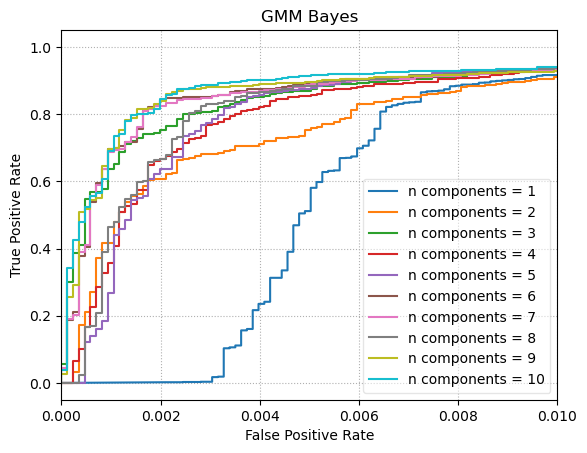

max score is for n=9


In [6]:
from astroML.classification import GMMBayes
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score


n_comps = np.arange(1,11)
scores = []
for i in n_comps:
    clf = GMMBayes(n_components=i)
    clf.fit(X_train[:, :4], y_train)
    y_prob = clf.predict_proba(X_test[:, :4])

    CVpredk = cross_val_predict(clf, X_train[:, :4], y_train)
    scores.append(accuracy_score(y_train, CVpredk))
    
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob[:,1])
    plt.plot(fpr, tpr, label=f'n components = %i' %i)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 0.01)
plt.grid(True, ls=':')
plt.legend(framealpha=0.5)
plt.title("GMM Bayes")

plt.show()

print("max score is for n={:d}".format(n_comps[np.argmax(scores)]))

#### Part 7

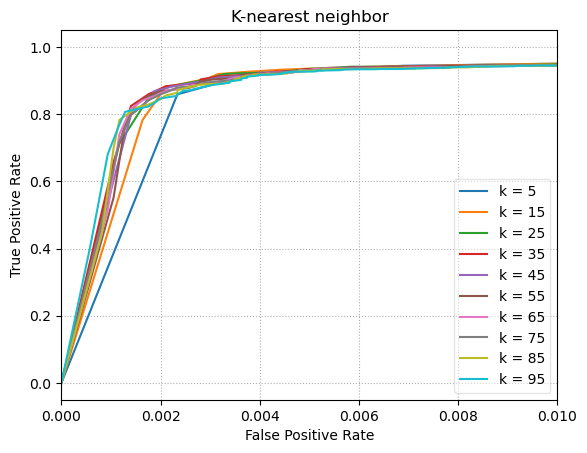

max score is for k=15


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


kvals = np.arange(5,100,10)

scores = []
#scores_knn = []
for i in kvals:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train[:, :4], y_train)
    y_prob = clf.predict_proba(X_test[:, :4])

    CVpredk = cross_val_predict(clf, X_train[:, :4], y_train)
    scores.append(accuracy_score(y_train, CVpredk))

    #pred = clf.predict(X_test[:, :4])
    #scores_knn.append(accuracy_score(y_test, pred))
    
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob[:,1])
    plt.plot(fpr, tpr, label=f'k = %i' %i)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 0.01)
plt.grid(True, ls=':')
plt.legend(framealpha=0.5)
plt.title("K-nearest neighbor")

plt.show()

print("max score is for k={:d}".format(kvals[np.argmax(scores)]))
#scores_knn

#### Part 8 

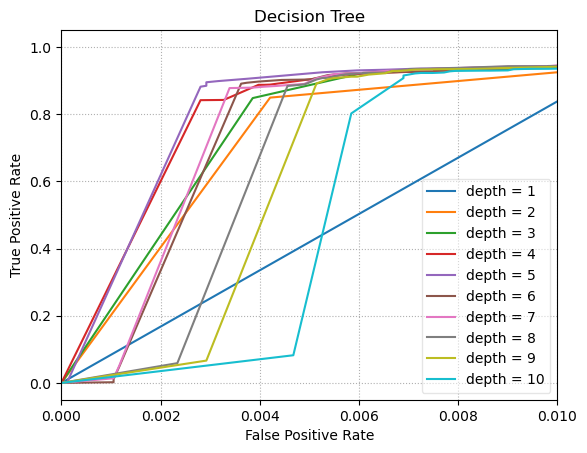

max score is for depth=7


In [18]:
from sklearn.tree import DecisionTreeClassifier


max_depth = np.arange(1,11,1)

scores = []
#scores_knn = []
for i in max_depth:
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train[:, :4], y_train)
    y_prob = clf.predict_proba(X_test[:, :4])

    CVpredk = cross_val_predict(clf, X_train[:, :4], y_train)
    scores.append(accuracy_score(y_train, CVpredk))

    #pred = clf.predict(X_test[:, :4])
    #scores_knn.append(accuracy_score(y_test, pred))
    
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob[:,1])
    plt.plot(fpr, tpr, label=f'depth = %i' %i)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 0.01)
plt.grid(True, ls=':')
plt.legend(framealpha=0.5)
plt.title("Decision Tree")

plt.show()

print("max score is for depth={:d}".format(max_depth[np.argmax(scores)]))

#### Part 9

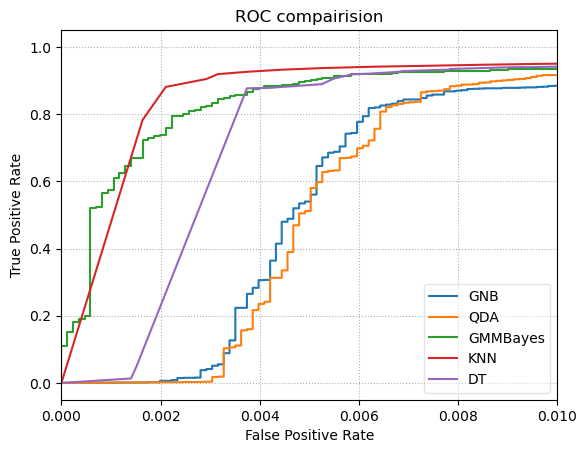

In [35]:
clfs = {'GNB' : GaussianNB(),
        'QDA' : QDA(), 
        'GMMBayes' : GMMBayes(n_components=9),
        'KNN' : KNeighborsClassifier(n_neighbors=15),
        'DT' : DecisionTreeClassifier(max_depth=7)
       }

for names, functions in clfs.items():
    model = functions
    model.fit(X_train[:, :4], y_train)
    y_prob = model.predict_proba(X_test[:, :4])[:, clf.classes_ == 1]
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob.flatten())
    plt.plot(fpr, tpr, label=names)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 0.01)
plt.grid(True, ls=':')
plt.legend(framealpha=0.5)
plt.title("ROC compairision")

plt.show()

#### Part 10

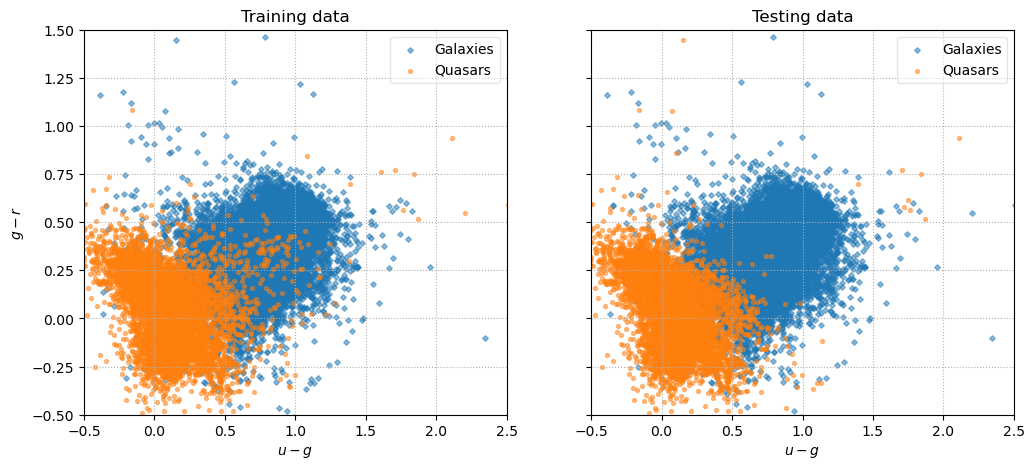

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)


u_m_g_train = X_train[:, 0] - X_train[:, 1]
g_m_r_train = X_train[:, 1] - X_train[:, 2]


ax1.scatter(u_m_g_train[y_train==0], g_m_r_train[y_train==0], c='tab:blue', marker='D', alpha=0.5, s=8, label='Galaxies')
ax1.scatter(u_m_g_train[y_train==1], g_m_r_train[y_train==1], c='tab:orange', alpha=0.5, s=8, label='Quasars')

ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 1.5)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')

ax1.legend(framealpha=0.5)
ax1.set_title('Training data')
ax1.grid(True, ls=':')



knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train[:, :4], y_train)
knn_predict = knn.predict(X_train[:, :4])

ax2.scatter(u_m_g_train[knn_predict==0], g_m_r_train[knn_predict==0], c='tab:blue', marker='D', alpha=0.5, s=8, label='Galaxies')
ax2.scatter(u_m_g_train[knn_predict==1], g_m_r_train[knn_predict==1], c='tab:orange', alpha=0.5, s=8, label='Quasars')

ax2.set_xlim(-0.5, 2.5)
ax2.set_ylim(-0.5, 1.5)

ax2.set_xlabel(r'$u-g$')

ax2.legend(framealpha=0.5)
ax2.set_title('Testing data')
ax2.grid(True, ls=':')

plt.show()